In [1]:
import gc
import math
import os
import time

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
import lightgbm as lgb
import pandas as pd

# from wrmsse import bild_WRMSSEEvaluator, WRMSSEEvaluator_learge
from reduce_mem import reduce_mem_usage
from wrmse import weight_calc

# データは従来のまま使いたい

In [2]:
result_dir = './result/new_set_seed/baseline_shop_no_price_again_add_4weekdays_stat_std_shop_cumsum_zerodem_dem_shop_std_no_roll/'
os.makedirs(result_dir, exist_ok=True)
print(result_dir)

./result/new_set_seed/baseline_shop_no_price_again_add_4weekdays_stat_std_shop_cumsum_zerodem_dem_shop_std_no_roll/


In [3]:

use_top_importance = False
num_features = 50



########################
print('########################')
# read_transfomed
print('read_transfomed_data')
t0 = time.time()
df_all = pd.read_pickle('./35093990_33386550_melt_over0sellprice.pkl')
df_all = reduce_mem_usage(df_all)
print(df_all.shape)
df_all = df_all.query('sell_price > 0')
print(df_all.shape)
t1 = time.time()
print('read_transfomed_data:{0}'.format(t1-t0) + '[sec]')
print('########################')
########################

########################
print('########################')
print('merge_features...')
print('before_merged_shape:{}'.format(df_all.shape))
t0_all = time.time()

f_paths = [
    './feature/shop/f_devine_ave_lag28demand_day_store_dept_no_roll.pkl',
    './feature/shop/f_diff_ave_lag28demand_day_store_dept_no_rolling.pkl',
    './feature/zero_demand/f_id_zero_demand.pkl',
    './feature/cumsum/f_id_cumsum_demand.pkl',
    './feature/shop/f_diff_ave_sales_day_store_dept_std.pkl',
    './feature/lag_demand/f_id_lag_demand_4weekdays_stat.pkl',
    './feature/shop/f_diff_ave_sales_day_store_dept.pkl',
    './feature/lag_demand/f_id_lag_demand.pkl',
    './feature/lag_sales/f_id_lag_sales.pkl'
]

for f_path in f_paths:
    t0 = time.time()
    print(f_path)
    df_f = pd.read_pickle(f_path)
    reduce_mem_usage(df_f)
    print('feature_shape:{}'.format(df_f.shape))
    df_all = pd.merge(df_all, df_f, on=['id', 'date'], how='left')
    del df_f
    gc.collect()
    print('merged_shape:{}'.format(df_all.shape))
    t1 = time.time()
    print('merged_time:{0}'.format(t1-t0) + '[sec]')

print('all_merge_done')
t1 = time.time()
print('all_merged_time:{0}'.format(t1-t0_all) + '[sec]')
print('########################')
########################


########################
print('########################')
print('date_features...')
print('before_date_shape:{}'.format(df_all.shape))

df_all['date'] = pd.to_datetime(df_all['date'])
# 対象
attrs = ["year", "month", "dayofweek", "is_year_end", "is_year_start"]
# is_year_end, is_year_srart

for attr in attrs:
    dtype = np.int16 if attr == "year" else np.int8
    print(attr)
    df_all[attr] = getattr(df_all['date'].dt, attr).astype(dtype)
df_all["is_weekend"] = df_all["dayofweek"].isin([5, 6]).astype(np.int8)
print('add_date_shape:{}'.format(df_all.shape))
t1 = time.time()
print('date_feature:{0}'.format(t1-t0) + '[sec]')
print('########################')
########################


########################
# setting_feature
print('df_all_col')
print(df_all.columns)
target_col = 'demand'
useless_cols = ['id', 'part',
                'date', 'wm_yr_wk', 'quarter', 'week', 'day',
                'is_quarter_end', 'is_quarter_start',
                'is_month_end', 'is_month_start',
                'release',
                # "is_year_end", "is_year_start"
                ]
# use: year, month, dayofweek, is_year_end, is_year_start, is_weekend
x_features = [col for col in df_all.columns if col not in list(useless_cols + [target_col])]

if use_top_importance:
    csv_path = os.path.join(result_dir, 'importances.csv')
    df_importance = pd.read_csv(csv_path)
    df_importance.sort_values('gain', ascending=False, inplace=True)
    x_features = list(df_importance.head(num_features)['feature'])
    result_dir = os.path.join(result_dir, 'use_top_{}_importance_features'.format(num_features))
    os.makedirs(result_dir, exist_ok=True)
    print(result_dir)


use_features = x_features + [target_col] + ['id', 'date']
x_features = list(set(x_features))

print('len_x_features:{}'.format(len(x_features)))
# sort
x_features = sorted(x_features)
print(x_features)
print('########################')

########################
read_transfomed_data
Mem. usage decreased to 1719.53 Mb (0.0% reduction)
(32782835, 18)
(32782835, 18)
read_transfomed_data:13.754868984222412[sec]
########################
########################
merge_features...
before_merged_shape:(32782835, 18)
./feature/shop/f_devine_ave_lag28demand_day_store_dept_no_roll.pkl
Mem. usage decreased to 875.40 Mb (30.0% reduction)
feature_shape:(32782835, 4)
merged_shape:(32782835, 20)
merged_time:28.74324107170105[sec]
./feature/shop/f_diff_ave_lag28demand_day_store_dept_no_rolling.pkl
Mem. usage decreased to 875.40 Mb (30.0% reduction)
feature_shape:(32782835, 4)
merged_shape:(32782835, 22)
merged_time:25.712233781814575[sec]
./feature/zero_demand/f_id_zero_demand.pkl
Mem. usage decreased to 1062.98 Mb (46.9% reduction)
feature_shape:(32782835, 7)
merged_shape:(32782835, 27)
merged_time:30.54291820526123[sec]
./feature/cumsum/f_id_cumsum_demand.pkl
Mem. usage decreased to 1250.57 Mb (28.6% reduction)
feature_shape:(3278283

# merticの導入

In [4]:
from metric import WRMSSEEvaluator

In [5]:
calendar = pd.read_csv("../../input/calendar.csv")
sales_train_validation = pd.read_csv("../../input/sales_train_validation.csv")
sell_prices = pd.read_csv( "../../input/sell_prices.csv")

evaluatorの準備

In [6]:
train_fold_df = sales_train_validation.copy() 
valid_fold_df = sales_train_validation.iloc[:, -28:].copy()

#インスタンスの作成
evaluator = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, sell_prices)

In [7]:
# df_id = sales_train_validation.iloc[:,:6].copy()
df_id = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]
df_id["all_id"] = 0
for i in range(12):
    df_weight = getattr(evaluator,"lv{}_weight".format(i+1)).reset_index() #evaluatorからweightを取得
    df_weight = df_weight.rename(columns = {0:"weight"})
    
    #各groupのsample数を計算
    group_keys = df_weight.columns[:-1].tolist()
    df_count = df_id.groupby(group_keys).count().id.reset_index()
    df_count = df_count.rename(columns = {"id":"n_sample"})
    
    df_weight = pd.merge(df_weight,df_count,how="left",on=(group_keys))
    assert df_weight.isnull().sum().sum()==0,"nullがあります"
    
    df_weight["weight_{}".format(i+1)] = df_weight["weight"] / df_weight["n_sample"] #weightの計算
    df_id = pd.merge(df_id,df_weight.drop(["weight","n_sample"],axis=1),how="left",on=(group_keys)) #df_idにマージ

#scaleの計算
df_scale = getattr(evaluator, f'lv{12}_train_df').reset_index()[["item_id","store_id","scale"]]
df_id = pd.merge(df_id,df_scale,how="left",on=(["item_id","store_id"]))

#最終weightの計算
# df_id["ajust_weight"] = df_id.iloc[:,7:19].mean(axis=1)*30490/np.sqrt(df_id["scale"]) #RMSSEはscaleにrootがあるので、rootをかけて補正
df_id["ajust_weight"] = df_id.iloc[:,7:19].mean(axis=1)*30490 #RMSSEはscaleにrootがあるので、rootをかけて補正

#必要な列だけ抽出
df_weight = pd.DataFrame()
df_weight["id"] = df_id["id"]
df_weight["ajust_weight"] = df_id["ajust_weight"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
df_weight.head()

,id,ajust_weight
0,HOBBIES_1_001_CA_1_validation,1.108836
1,HOBBIES_1_002_CA_1_validation,0.770340
2,HOBBIES_1_003_CA_1_validation,0.808712
3,HOBBIES_1_004_CA_1_validation,1.297677
4,HOBBIES_1_005_CA_1_validation,0.935565


# scaleの調整

In [9]:
df_id

,id,item_id,dept_id,cat_id,store_id,state_id,all_id,weight_1,weight_2,weight_3,...,weight_5,weight_6,weight_7,weight_8,weight_9,weight_10,weight_11,weight_12,scale,ajust_weight
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0.000033,0.000036,0.000036,...,0.000029,0.000026,0.000034,0.000032,0.000041,0.000032,0.000054,0.000060,1.363636,1.108836
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0.000033,0.000036,0.000036,...,0.000029,0.000026,0.000034,0.000032,0.000041,0.000007,0.000003,0.000002,0.611864,0.770340
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0.000033,0.000036,0.000036,...,0.000029,0.000026,0.000034,0.000032,0.000041,0.000007,0.000009,0.000013,0.784653,0.808712
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0.000033,0.000036,0.000036,...,0.000029,0.000026,0.000034,0.000032,0.000041,0.000055,0.000102,0.000063,7.185935,1.297677
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0.000033,0.000036,0.000036,...,0.000029,0.000026,0.000034,0.000032,0.000041,0.000020,0.000029,0.000029,2.668517,0.935565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0.000033,0.000032,0.000028,...,0.000043,0.000043,0.000042,0.000038,0.000041,0.000011,0.000005,0.000005,1.341183,0.911506
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0.000033,0.000032,0.000028,...,0.000043,0.000043,0.000042,0.000038,0.000041,0.000009,0.000008,0.000006,1.038260,0.918653
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,0.000033,0.000032,0.000028,...,0.000043,0.000043,0.000042,0.000038,0.000041,0.000035,0.000042,0.000027,2.298117,1.123295
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0.000033,0.000032,0.000028,...,0.000043,0.000043,0.000042,0.000038,0.000041,0.000012,0.000011,0.000009,2.174538,0.942609


In [10]:
df_scale = df_id[["id","scale"]]
df_all = pd.merge(df_all, df_scale, how="left", on="id")

In [11]:
x_features

['0demand_lag_28_roll_sum_180',
 '0demand_lag_28_roll_sum_30',
 '0demand_lag_28_roll_sum_60',
 '0demand_lag_28_roll_sum_7',
 '0demand_lag_28_roll_sum_90',
 '4weekdays_max',
 '4weekdays_mean',
 '4weekdays_min',
 '4weekdays_std',
 'cat_id',
 'day_store_dept_sales_mean_lag28_demand',
 'day_store_dept_sales_mean_price',
 'day_store_dept_sales_std_lag28_demand',
 'day_store_dept_sales_std_price',
 'dayofweek',
 'demand_cumsum_lag_180',
 'demand_cumsum_lag_28',
 'demand_cumsum_lag_364',
 'demand_cumsum_lag_90',
 'demand_lag_28_roll_kurt_30',
 'demand_lag_28_roll_mean_180',
 'demand_lag_28_roll_mean_30',
 'demand_lag_28_roll_mean_60',
 'demand_lag_28_roll_mean_7',
 'demand_lag_28_roll_mean_90',
 'demand_lag_28_roll_skew_30',
 'demand_lag_28_roll_std_180',
 'demand_lag_28_roll_std_30',
 'demand_lag_28_roll_std_60',
 'demand_lag_28_roll_std_7',
 'demand_lag_28_roll_std_90',
 'demand_lag_28_x',
 'demand_lag_28_y',
 'demand_lag_29',
 'demand_lag_30',
 'demand_lag_35',
 'demand_lag_42',
 'demand_l

In [12]:
scale_cols = [
    'demand',
    'day_store_dept_sales_mean_lag28_demand',
    'demand_lag_28_roll_mean_180',    'demand_lag_28_roll_mean_30',    'demand_lag_28_roll_mean_60',    'demand_lag_28_roll_mean_7',    'demand_lag_28_roll_mean_90',
    'demand_lag_28_x', 'demand_lag_28_y', 'demand_lag_29', 'demand_lag_30', 'demand_lag_35', 'demand_lag_42', 'demand_lag_49',
    '4weekdays_mean'
]

In [13]:
print('scale')
for col in scale_cols:
    print(col)
    df_all[col] = df_all[col] / np.sqrt(df_all["scale"])

scale
demand
day_store_dept_sales_mean_lag28_demand
demand_lag_28_roll_mean_180
demand_lag_28_roll_mean_30
demand_lag_28_roll_mean_60
demand_lag_28_roll_mean_7
demand_lag_28_roll_mean_90
demand_lag_28_x
demand_lag_28_y
demand_lag_29
demand_lag_30
demand_lag_35
demand_lag_42
demand_lag_49
4weekdays_mean


In [14]:
df_all = df_all.drop("scale", axis=1)

# 学習

In [15]:
tr_val_date = {
    '1st': {
        'train_end_date': '2016-02-28',
        'val_end_date': '2016-03-27',
        'train_end_date_num': 1857
        
    },
    '2nd': {
        'train_end_date': '2016-03-27',
        'val_end_date': '2016-04-24',
        'train_end_date_num': 1885
    }
}

In [16]:
########################
print('########################')
print('make_holdout')
t0 = time.time()
df_all = df_all[use_features]
print('rm_same_name_col')
print(df_all.shape)
df_all = df_all.loc[:, ~df_all.columns.duplicated()]
print(df_all.shape)

print('sep...')
df_test = df_all.query('date > "2016-04-24" and date <= "2016-05-22"')

########################
make_holdout
rm_same_name_col
(32782835, 68)
(32782835, 68)
sep...


In [17]:
params = {
    'metric': 'rmse',
    'objective': 'poisson',
    'n_jobs': -1,
    'seed': 20,
    'learning_rate': 0.05,
    'alpha': 0.1,
    'lambda': 0.1,
    'bagging_fraction': 0.66,
    'bagging_freq': 2,
    'colsample_bytree': 0.77
    }


In [18]:
#元dfに対して予測して、wide_formatで返す関数
# df_features：特徴量とtarget(true)を含むdf
# df_keys：wide_formatに戻す際に必要となるkeysが入ったdf
def pred_and_convert_wide(df_features, x_features, df_keys,model, df_scale=None):
    #dfの作成
    pred_df = pd.DataFrame()
    pred_df["demand"] = model.predict(df_features[x_features])
    pred_df['id'] = list(df_features['id'])
    pred_df['date'] = list(df_features['date'])

    if df_scale is not None:
        df_scale_tmp = df_scale.copy()
        pred_df = pd.merge(pred_df,  df_scale_tmp,how="left",on="id")
        pred_df["demand"] = pred_df["demand"] * np.sqrt(pred_df["scale"])
        pred_df = pred_df.drop("scale",axis=1)
    
    print(pred_df.head())
    #submission用に変換
    pred_df = pd.pivot(pred_df, index = 'id', columns = 'date', values = 'demand').reset_index()
    
    return pred_df


va:2016-02-28-2016-03-27
df_train:(29367955, 68)_df_val:(853720, 68)
caluculate_weight...
build_evaluater...



train...
train
Training until validation scores don't improve for 200 rounds
[50]	training's rmse: 0.787091	valid_1's rmse: 0.858785
[100]	training's rmse: 0.774361	valid_1's rmse: 0.842866
[150]	training's rmse: 0.77077	valid_1's rmse: 0.837394
[200]	training's rmse: 0.768375	valid_1's rmse: 0.834317
[250]	training's rmse: 0.766641	valid_1's rmse: 0.83243
[300]	training's rmse: 0.765254	valid_1's rmse: 0.831178
[350]	training's rmse: 0.764268	valid_1's rmse: 0.83054
[400]	training's rmse: 0.763333	valid_1's rmse: 0.830024
[450]	training's rmse: 0.7625	valid_1's rmse: 0.829674
[500]	training's rmse: 0.761823	valid_1's rmse: 0.829374
[550]	training's rmse: 0.761199	valid_1's rmse: 0.8291
[600]	training's rmse: 0.760633	valid_1's rmse: 0.828763
[650]	training's rmse: 0.760107	valid_1's rmse: 0.828594
[700]	training's rmse: 0.759561	valid_1's rmse: 0.828446
[750]	training's rmse: 0.759151	valid_1's rmse: 0.82832
[800]	training's rmse: 0.758653	valid_1's rmse: 0.828133
[850]	training's rm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


     demand                             id       date
0  0.655660  HOBBIES_1_001_CA_1_validation 2016-02-29
1  0.265680  HOBBIES_1_002_CA_1_validation 2016-02-29
2  0.267105  HOBBIES_1_003_CA_1_validation 2016-02-29
3  1.975897  HOBBIES_1_004_CA_1_validation 2016-02-29
4  0.870868  HOBBIES_1_005_CA_1_validation 2016-02-29
WRMSSE： 0.634
va:2016-03-27-2016-04-24
df_train:(30221675, 68)_df_val:(853720, 68)
caluculate_weight...
build_evaluater...



train...
train
Training until validation scores don't improve for 200 rounds
[50]	training's rmse: 0.789068	valid_1's rmse: 0.869769
[100]	training's rmse: 0.776329	valid_1's rmse: 0.85065
[150]	training's rmse: 0.7726	valid_1's rmse: 0.843283
[200]	training's rmse: 0.77028	valid_1's rmse: 0.839811
[250]	training's rmse: 0.768611	valid_1's rmse: 0.837531
[300]	training's rmse: 0.767294	valid_1's rmse: 0.836298
[350]	training's rmse: 0.766211	valid_1's rmse: 0.835466
[400]	training's rmse: 0.765264	valid_1's rmse: 0.834803
[450]	training's rmse: 0.76442	valid_1's rmse: 0.834263
[500]	training's rmse: 0.763731	valid_1's rmse: 0.833924
[550]	training's rmse: 0.763127	valid_1's rmse: 0.833448
[600]	training's rmse: 0.762544	valid_1's rmse: 0.833257
[650]	training's rmse: 0.761998	valid_1's rmse: 0.832967
[700]	training's rmse: 0.761531	valid_1's rmse: 0.832699
[750]	training's rmse: 0.761089	valid_1's rmse: 0.832472
[800]	training's rmse: 0.760668	valid_1's rmse: 0.832159
[850]	training's

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


     demand                             id       date
0  0.779943  HOBBIES_1_001_CA_1_validation 2016-03-28
1  0.219414  HOBBIES_1_002_CA_1_validation 2016-03-28
2  0.258412  HOBBIES_1_003_CA_1_validation 2016-03-28
3  1.780297  HOBBIES_1_004_CA_1_validation 2016-03-28
4  0.942884  HOBBIES_1_005_CA_1_validation 2016-03-28
WRMSSE： 0.5463


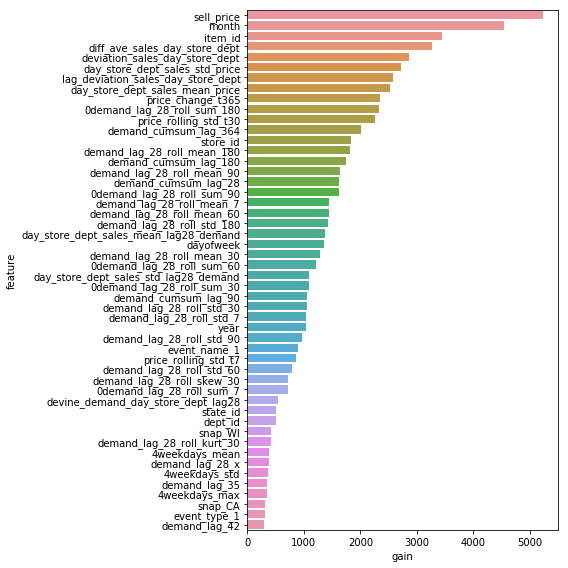

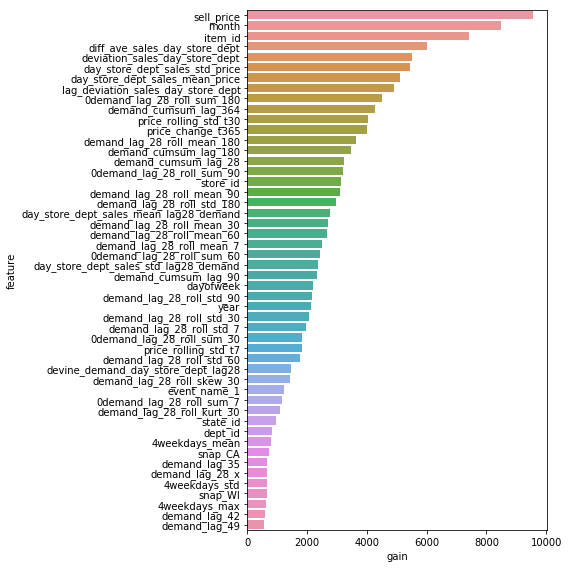

In [19]:
model_list = []
imp_df_list = []
evaluator_list = []
wrmsse_score_list = []
valid_true_df_list = []
valid_pred_df_list = []
eval_result_list = []


for num in ['1st', '2nd']:
    train_end_date = tr_val_date[num]['train_end_date']
    val_end_date = tr_val_date[num]['val_end_date']
    print(f'va:{train_end_date}-{val_end_date}')
    df_train = df_all.query('date <= @train_end_date')
    df_val = df_all.query('date > @train_end_date and date <= @val_end_date')
    print('df_train:{}_df_val:{}'.format(df_train.shape, df_val.shape, ))
    #weightを計算
    print('caluculate_weight...')
    ajust_weight_train = pd.merge(df_train['id'], df_weight, how="left", on="id")['ajust_weight']
    ajust_weight_val = pd.merge(df_val['id'], df_weight, how="left", on="id")['ajust_weight']
    
    if num == '1st':
        train_fold_df = sales_train_validation.copy() #weightの期間を変更
        valid_fold_df = sales_train_validation.iloc[:, -56:-28].copy()
    else:
        train_fold_df = sales_train_validation.copy() #weightの期間を変更
        valid_fold_df = sales_train_validation.iloc[:, -28:].copy()
    valid_true_df_list.append(valid_fold_df)
    
    #インスタンスの作成
    print('build_evaluater...')
    evaluator = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, sell_prices)
    evaluator_list.append(evaluator)
    
    print('train...')
    train_set = lgb.Dataset(df_train[x_features], df_train[target_col], weight=ajust_weight_train)
    val_set = lgb.Dataset(df_val[x_features], df_val[target_col], weight=ajust_weight_val)
    print('train')
    evals_result = {}
    model = lgb.train(
            params,
            train_set,
            num_boost_round=5000,
            early_stopping_rounds=200,
            valid_sets=[train_set, val_set],
    #         feval=evaluator.feval,
            verbose_eval=50)
    # 書き出し
    model_path = os.path.join(result_dir, f'model_{num}.lgb')
    model.save_model(model_path)
    
    # 予測
    y_pred = model.predict(df_test[x_features], num_iteration=model.best_iteration)
    df_test['demand'] += y_pred / 2.
    
    # 重要度
    importances = pd.DataFrame()
    importances['feature'] = x_features
    importances['gain'] = model.feature_importance()
    def save_importances(importances_: pd.DataFrame):
        csv_path = os.path.join(result_dir, f'{num}_importances.csv')
        importances_.to_csv(csv_path, index=False)
        plt.figure(figsize=(8, 8))
        sns.barplot(
            x='gain',
            y='feature',
            data=importances_.sort_values('gain', ascending=False)[:50])
        png_path = os.path.join(result_dir, f'{num}_importances.png')
        plt.tight_layout()
        plt.savefig(png_path)

    save_importances(importances)
    
    model_list.append(model)
    imp_df_list.append(importances)
    eval_result_list.append(evals_result)
    
    #WRMSSEの算出
    id_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    X_val_wide = pred_and_convert_wide(df_val ,x_features, df_val[["id","date"]].copy(), model, df_scale)
    X_val_wide.columns = ['id'] + ['d_' + str(i + 1) for i in range(tr_val_date[num]['train_end_date_num'], tr_val_date[num]['train_end_date_num']+28)]
    valid_preds = pd.merge(train_fold_df[id_columns].copy(), X_val_wide, how="left",on="id")
    valid_pred_df_list.append(valid_preds)
    #スコアの算出
    wrmsse_score = evaluator.score(valid_preds.iloc[:,6:]) #id列は削除して渡す
    wrmsse_score_list.append(wrmsse_score)
    print("WRMSSE：",round(wrmsse_score, 4))

# 可視化

In [20]:
def plot_timeseries_summary(valid_pred_df_list,valid_true_df_list,sales_train_validation,plot_col):

    sales_train_validation["all"] = 0

    #predsの作成
    id_cols = ["id","item_id","dept_id","cat_id","store_id","state_id","all"] #allを追加
    drop_cols = [x for x in id_cols if x not in plot_col] #plot_colにない値だけを返す

    preds_list = []
    truth_list = []

    for preds, truth in zip(valid_pred_df_list,valid_true_df_list):
        #予測データ
        preds["all"] = 0
        X_val_preds_T = preds.drop(drop_cols,axis=1).groupby(plot_col).sum().T.reset_index().rename(columns={"index":"day"})
        preds_list.append(X_val_preds_T)

        #正解データ
        X_val_truth_T = pd.concat([sales_train_validation[plot_col],truth],axis=1).groupby(plot_col).sum().T.reset_index().rename(columns={"index":"day"})
        truth_list.append(X_val_truth_T)


    if type(plot_col) == list:
        plot_col = plot_col[0]

    #plot
    n_plot = len(X_val_preds_T.columns)-1
    n_row = math.ceil(n_plot/3)
    plt.figure(figsize=[30,n_row*7])

    if plot_col == "all":
        for i in range(2):
            plt.subplot(n_row,2,i+1)
            for j,col in enumerate(preds_list[i].columns[1:]):
                sns.lineplot(x="day",y=col,data=truth_list[i])
                sns.lineplot(x="day",y=col,data=preds_list[i])
                plt.ylabel("sales")
                plt.xticks(valid_true_df_list[i].columns.tolist()[::7])
                plt.title("all sales in validation{}".format(i),fontsize=18)
                plt.legend(["truth","preds"])

In [21]:
#予測値の可視化（Validation期間）
def plot_timeseries(X_val_preds,valid_fold_df,sales_train_validation,plot_col,n_val):

    sales_train_validation["all"] = 0
    X_val_preds["all"] = 0

    #predsの作成
    id_cols = ["id","item_id","dept_id","cat_id","store_id","state_id","all"] #allを追加
    drop_cols = [x for x in id_cols if x not in plot_col] #plot_colにない値だけを返す
    #予測データ
    X_val_preds_T = X_val_preds.drop(drop_cols,axis=1).groupby(plot_col).sum().T.reset_index().rename(columns={"index":"day"})
    #正解データ
    X_val_truth_T = pd.concat([sales_train_validation[plot_col],valid_fold_df],axis=1).groupby(plot_col).sum().T.reset_index().rename(columns={"index":"day"})

    if type(plot_col) == list:
        plot_col = plot_col[0]

    #plot
    n_plot = len(X_val_preds_T.columns)-1
    n_row = math.ceil(n_plot/3)
    plt.figure(figsize=[30,n_row*7])

    if plot_col == "all":
        for i,col in enumerate(X_val_preds_T.columns[1:]):
            sns.lineplot(x="day",y=col,data=X_val_truth_T)
            sns.lineplot(x="day",y=col,data=X_val_preds_T)
            plt.ylabel("sales")
            plt.xticks(valid_fold_df.columns.tolist()[::7])
            plt.title("all sales in validation{}".format(n_val),fontsize=18)
            plt.legend(["truth","preds"])
    
    else:
        for i,col in enumerate(X_val_preds_T.columns[1:]):
            plt.subplot(n_row,3,i+1) #横に3つずつプロットする
            # plt.subplots_adjust(wspace=0.1,top=0.5)
            plt.suptitle("{} validation{}".format(plot_col,n_val),fontsize=24,va="bottom",y=0.9) #super titleの設定
            sns.lineplot(x="day",y=col,data=X_val_truth_T)
            sns.lineplot(x="day",y=col,data=X_val_preds_T)
            plt.ylabel("sales")
            plt.xticks(valid_fold_df.columns.tolist()[::7])
            plt.title("{} sales in validation{}".format(col,n_val),fontsize=18)
            plt.legend(["truth","preds"])


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


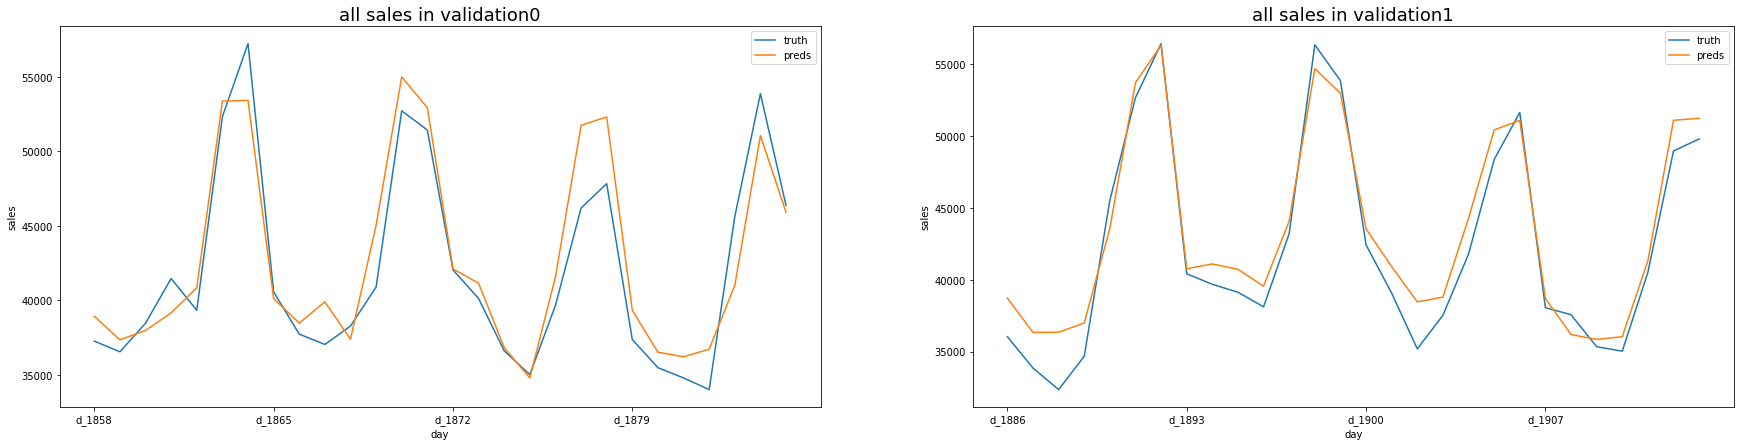

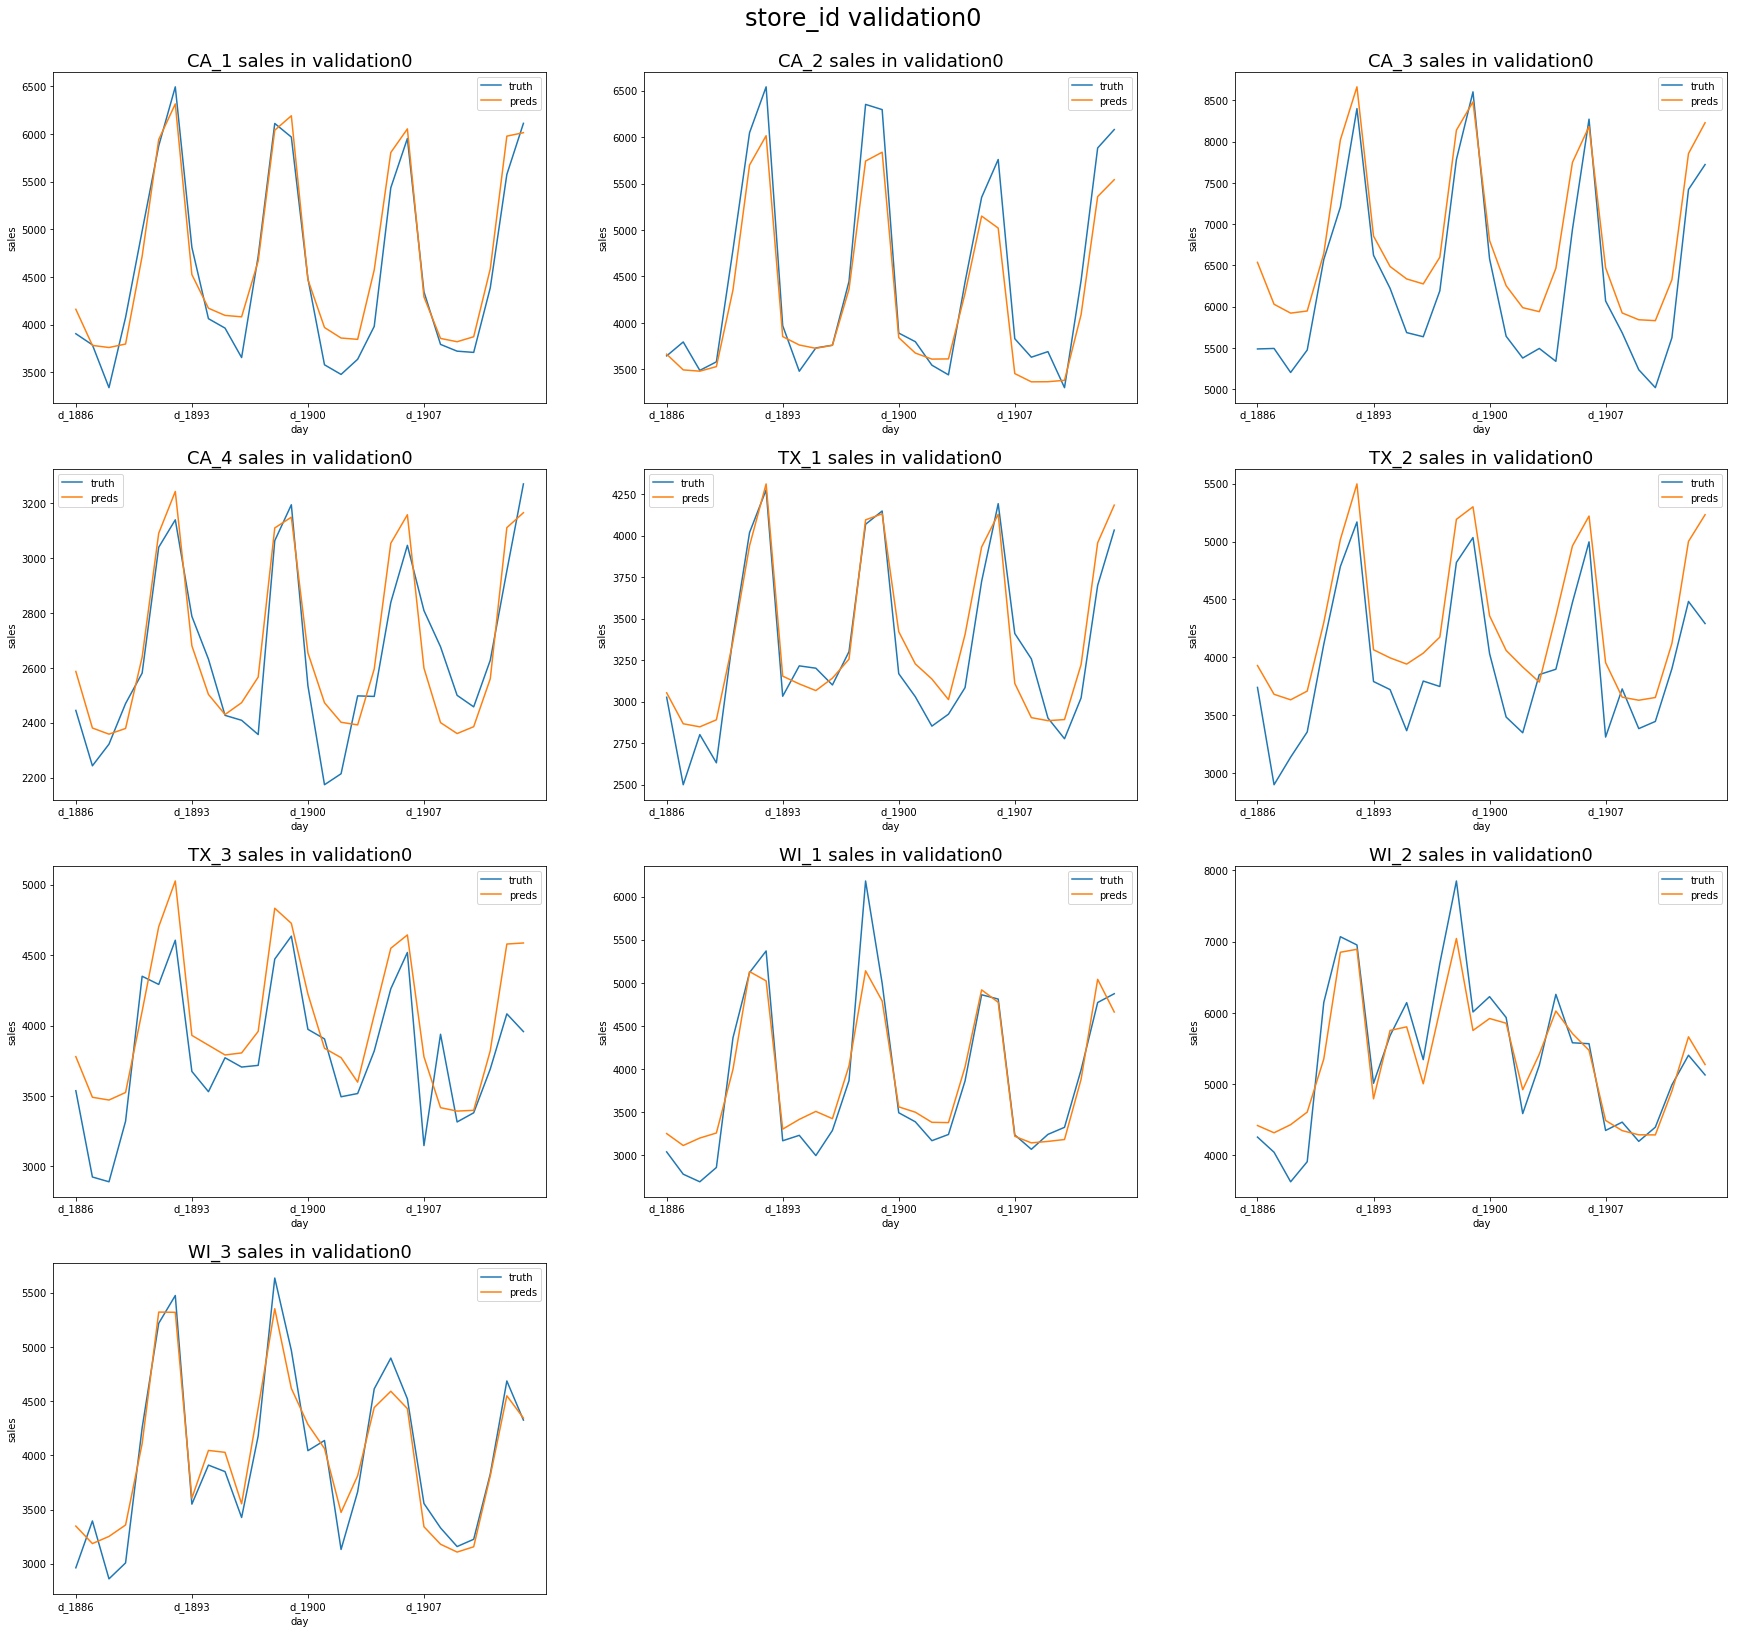

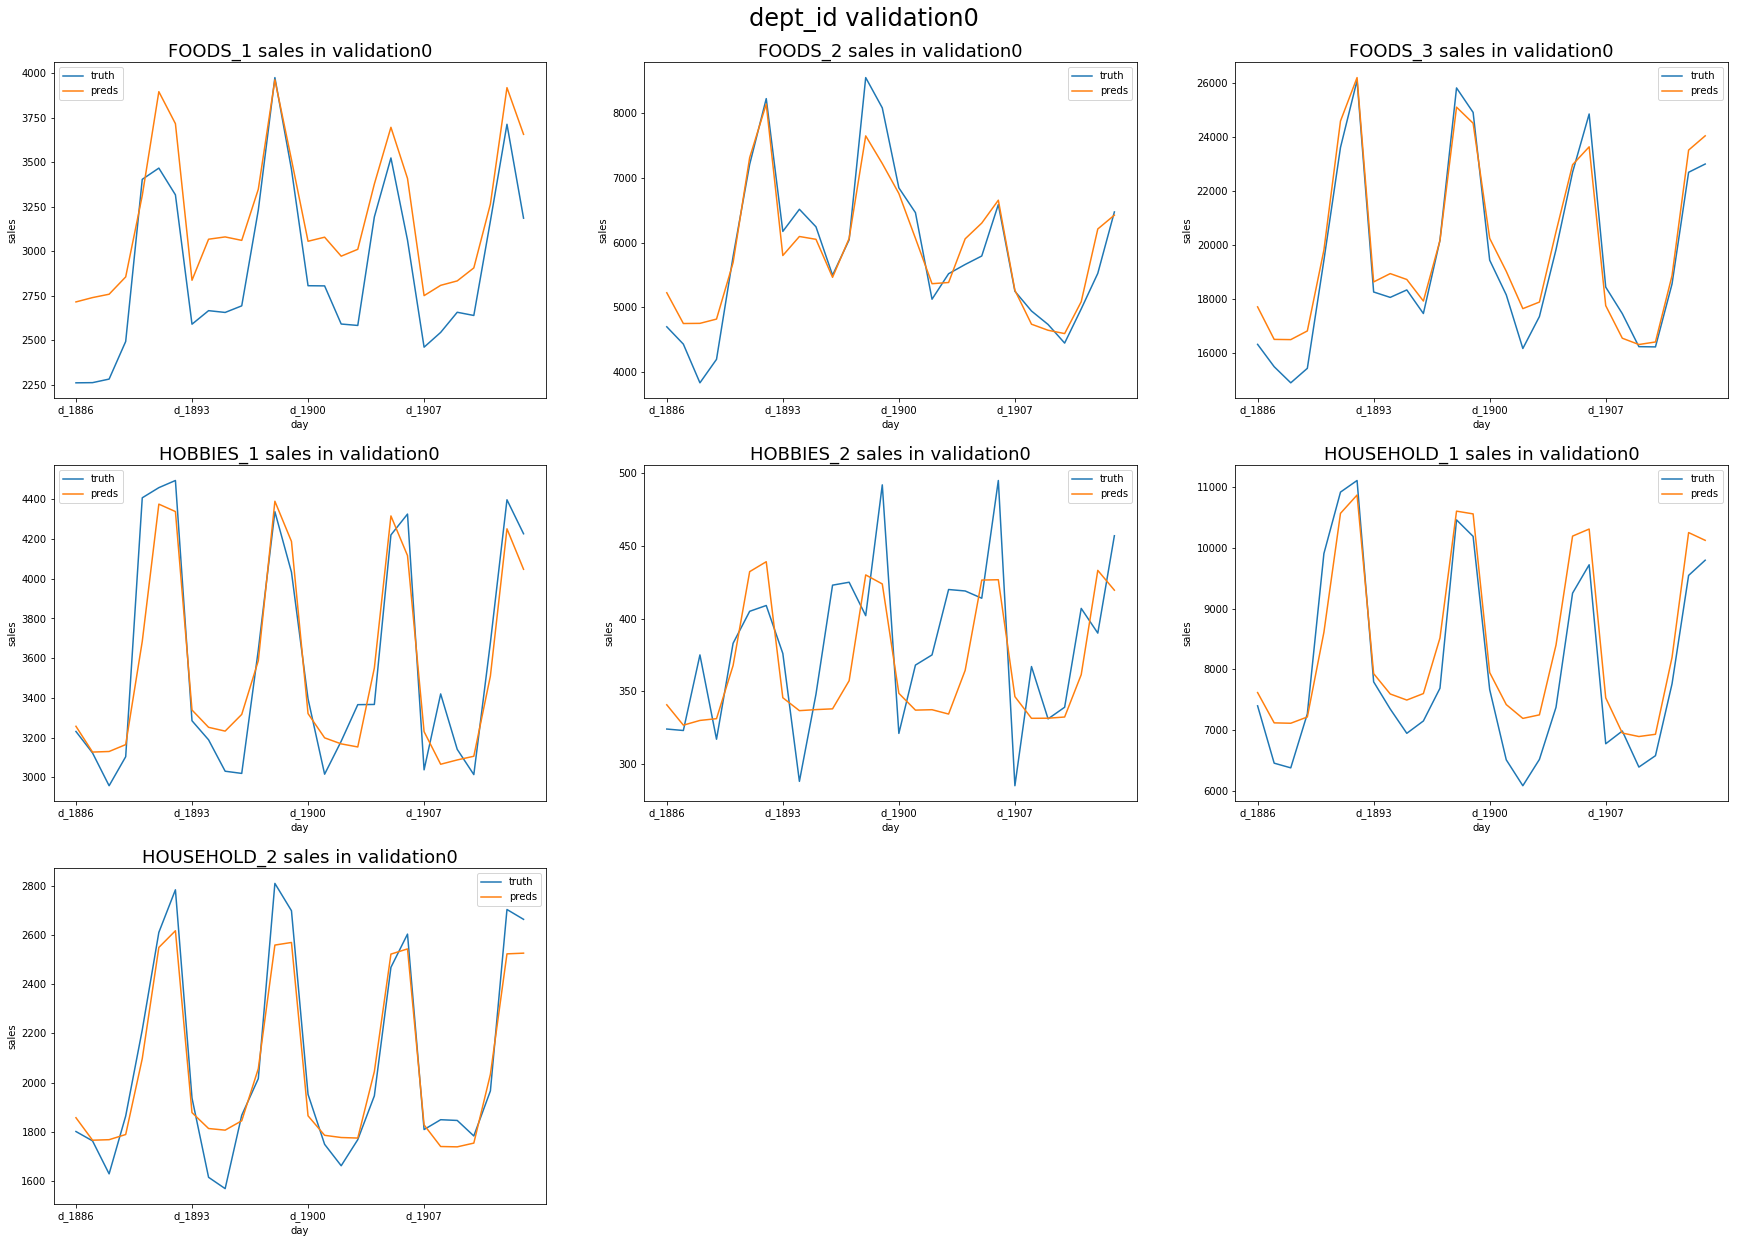

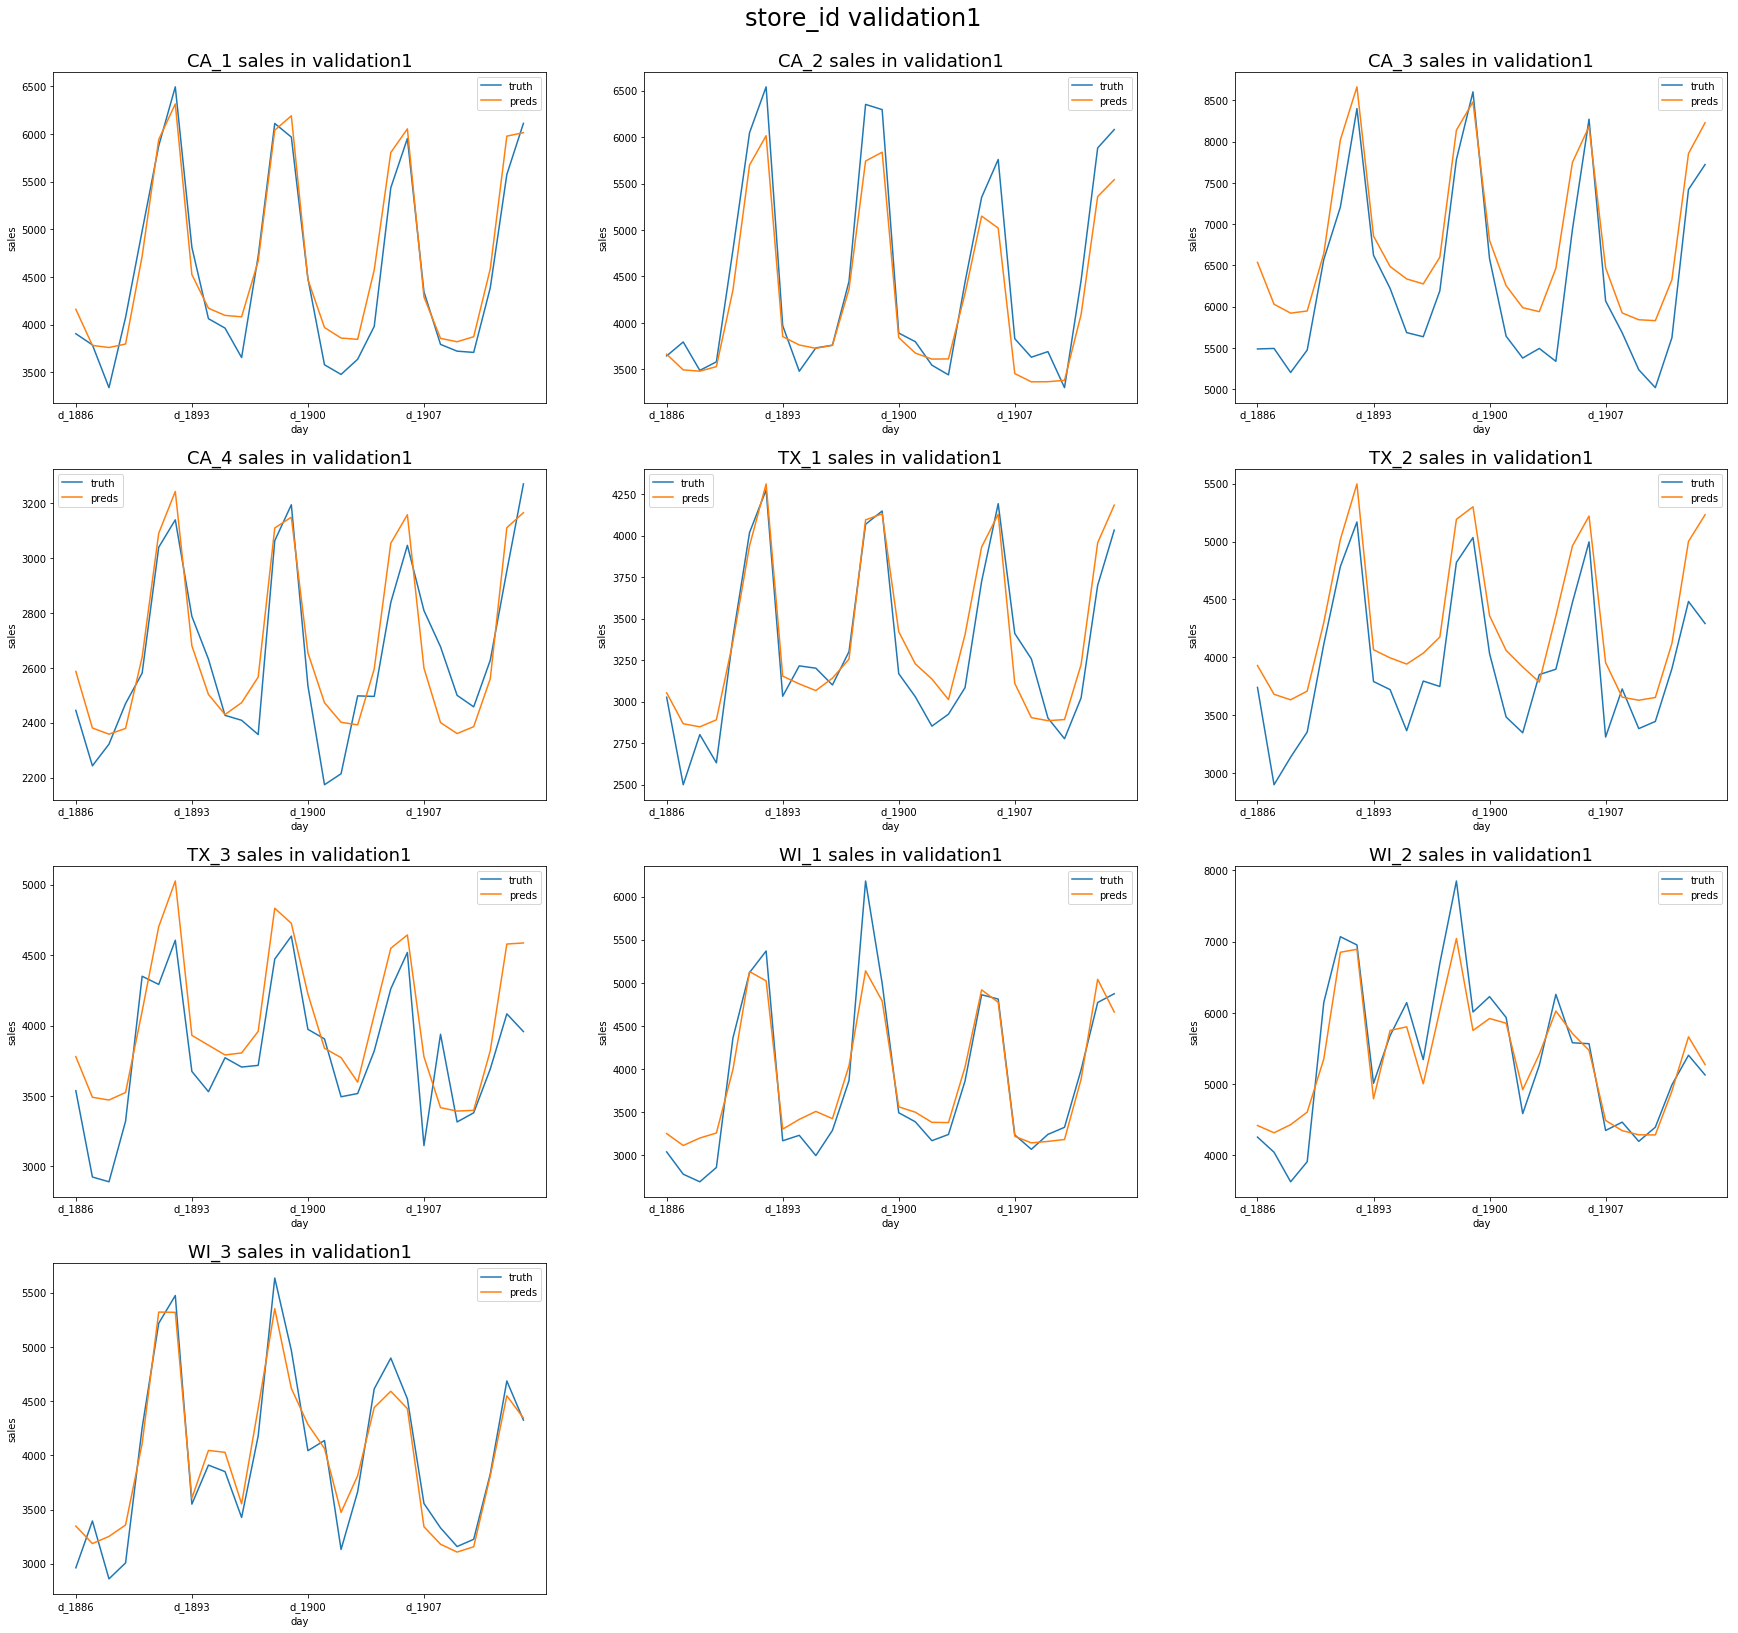

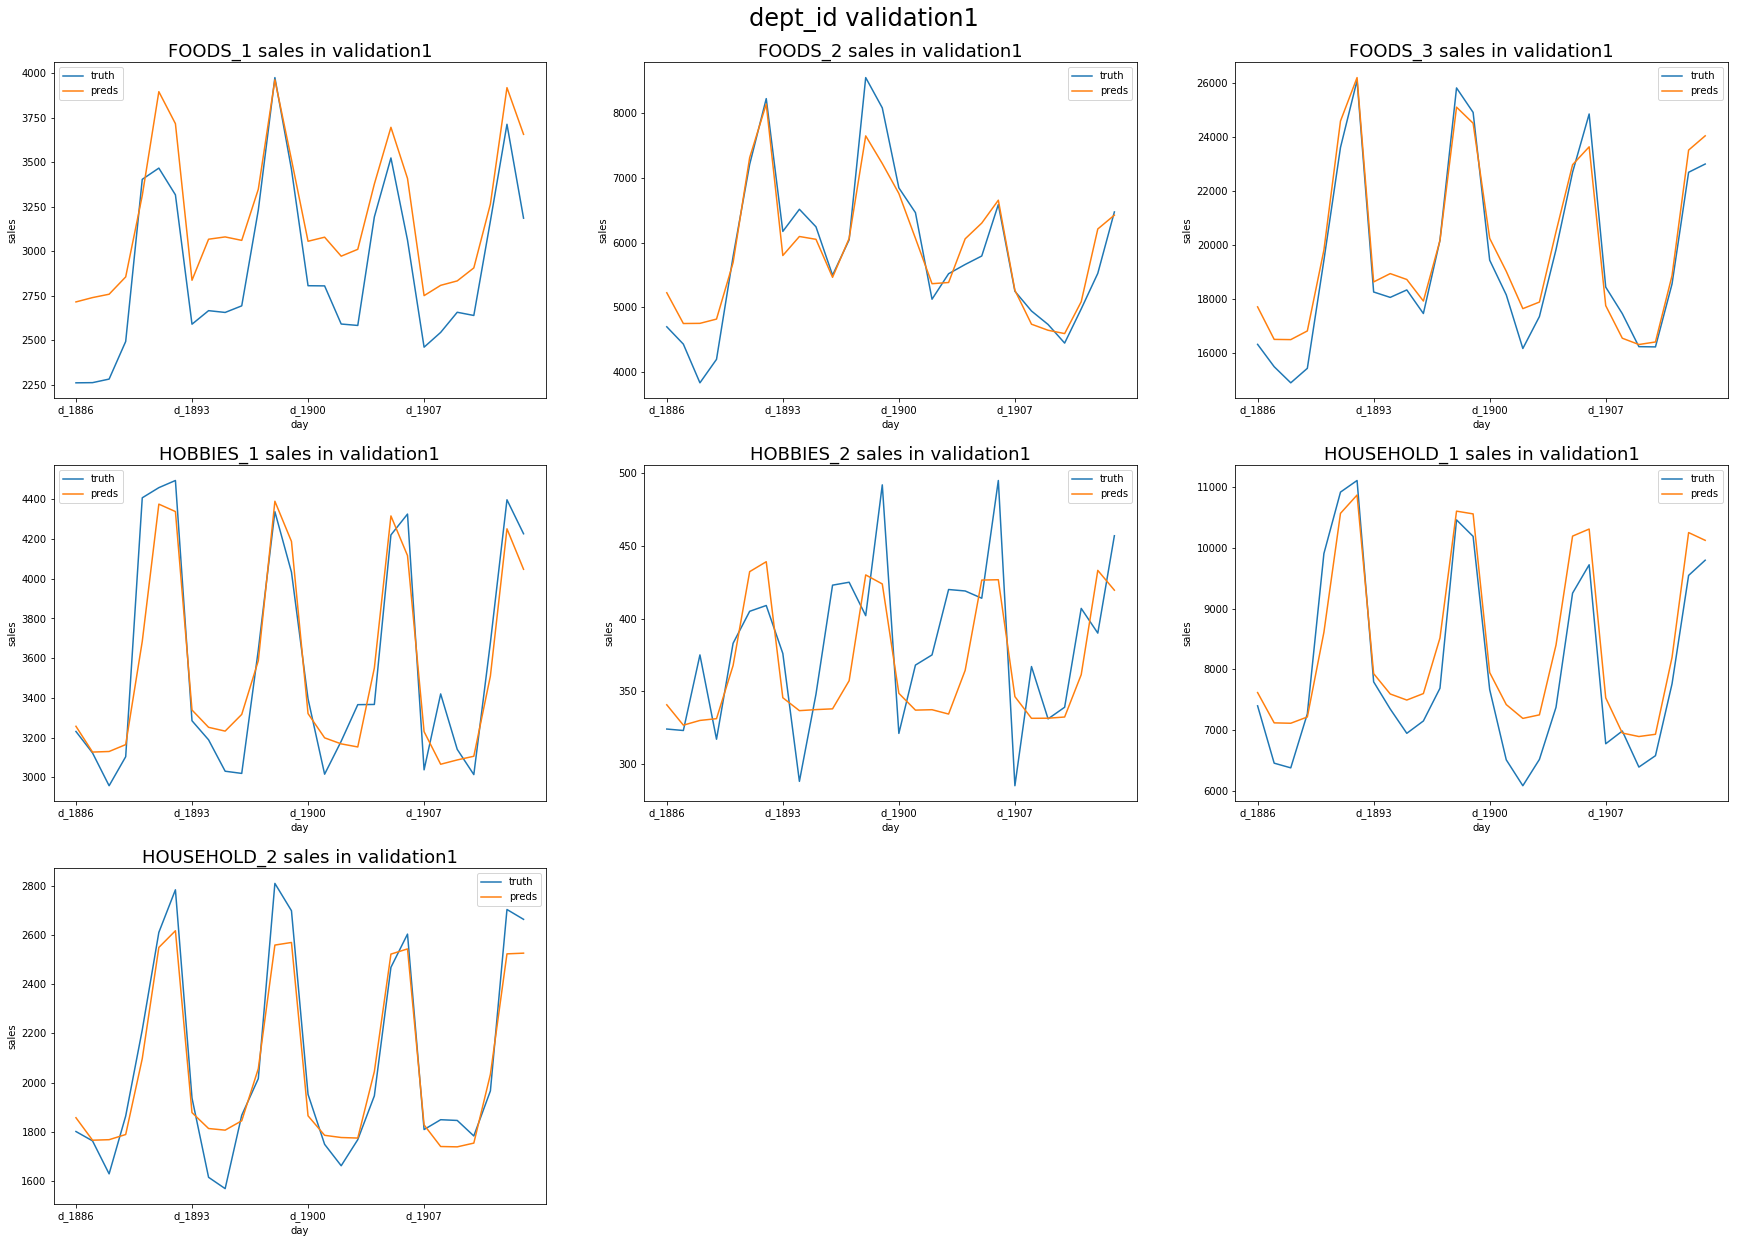

In [22]:
# plot_col_list = ["all","store_id","dept_id"]
plot_col_list = ["store_id","dept_id"]
plot_timeseries_summary(valid_pred_df_list,valid_true_df_list,sales_train_validation,plot_col="all")# allだけ
for i in range(2):
    for plot_col in plot_col_list:
        plot_timeseries(valid_preds,valid_fold_df,sales_train_validation,plot_col,i)

In [31]:
pred_df = pd.merge(df_test,df_scale,how="left",on="id")
pred_df["demand"] = pred_df["demand"] * np.sqrt(pred_df["scale"])

In [32]:
pred_df['demand']

0         0.808580
1         0.316432
2         0.352841
3         2.038041
4         1.060859
            ...   
853715    0.456517
853716    0.356931
853717    0.939361
853718    1.062403
853719    1.193833
Name: demand, Length: 853720, dtype: float64

In [33]:
df_test['demand']

31075395    0.692427
31075396    0.404531
31075397    0.398327
31075398    0.760276
31075399    0.649415
              ...   
31929110    0.394197
31929111    0.350293
31929112    0.619650
31929113    0.720453
31929114    0.459257
Name: demand, Length: 853720, dtype: float64

# 書き出し

In [34]:
def predict(test, submission, csv_path):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index='id', columns='date', values='demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row]
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on='id')
    final = pd.concat([validation, evaluation])
    print(final.head())
    print(final.shape)
    final.to_csv(csv_path, index=False)

In [35]:
submission = pd.read_csv('../input/sample_submission.csv')
csv_path = os.path.join(result_dir, 'sub.csv')
predict(pred_df, submission, csv_path)

                              id        F1        F2        F3        F4  \
0  HOBBIES_1_001_CA_1_validation  0.808580  0.726239  0.681725  0.636556   
1  HOBBIES_1_002_CA_1_validation  0.316432  0.287046  0.284395  0.281851   
2  HOBBIES_1_003_CA_1_validation  0.352841  0.322669  0.315961  0.317839   
3  HOBBIES_1_004_CA_1_validation  2.038041  1.635386  1.676413  1.763260   
4  HOBBIES_1_005_CA_1_validation  1.060859  0.862804  1.002252  1.057752   

         F5        F6        F7        F8        F9  ...       F19       F20  \
0  0.759554  0.854727  0.943090  0.677327  0.726305  ...  0.803497  1.220644   
1  0.321697  0.375879  0.373583  0.268633  0.221438  ...  0.223339  0.277813   
2  0.381476  0.425932  0.472174  0.337400  0.319092  ...  0.427641  0.550680   
3  1.962220  2.410707  2.376822  1.698373  1.658578  ...  1.943805  2.389177   
4  1.131071  1.394497  1.576665  1.127492  1.131076  ...  1.121878  1.410998   

        F21       F22       F23       F24       F25       F26 

In [36]:
len(x_features)

65